In [1]:
import pandas as pd
import pickle
%pylab inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures,RobustScaler

import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
horror_df=pd.read_pickle('horror_df.pkl')
horror_df

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Novel_Adaptation,Male_Score,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder
0,Psycho,1960,109,"[Horror, Mystery, Thriller ]",8.5,602815,97,Alfred Hitchcock,"[Anthony Perkins, Janet Leigh, Vera Miles]",806947,...,1,8.5,353389,8.4,88145,/title/tt0054215/,0,0,1,1
1,The Shining,1980,146,"[Drama, Horror ]",8.4,896027,66,Stanley Kubrick,"[Jack Nicholson, Shelley Duvall, Danny Lloyd]",19000000,...,1,8.4,530475,8.3,124287,/title/tt0081505/,0,0,1,1
2,Alien,1979,117,"[Horror, Sci-Fi ]",8.4,786083,89,Ridley Scott,"[Sigourney Weaver, Tom Skerritt, John Hurt]",11000000,...,0,8.5,507612,8.2,73461,/title/tt0078748/,1,1,1,1
3,The Thing,1982,109,"[Horror, Mystery, Sci-Fi ]",8.1,370424,57,John Carpenter,"[Kurt Russell, Wilford Brimley, Keith David]",15000000,...,0,8.2,252886,7.7,28831,/title/tt0084787/,0,1,1,1
4,What Ever Happened to Baby Jane?,1962,134,"[Drama, Horror, Thriller ]",8.1,49967,75,Robert Aldrich,"[Bette Davis, Joan Crawford, Victor Buono]",980000,...,1,8.0,28768,8.3,10292,/title/tt0056687/,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,0,3.2,14850,3.4,4180,/title/tt5690360/,0,1,0,1
680,Jaws: The Revenge,1987,89,"[Adventure, Horror, Thriller ]",3.0,41154,15,Joseph Sargent,"[Lorraine Gary, Lance Guest, Mario Van Peebles]",23000000,...,0,2.9,27697,3.6,3417,/title/tt0093300/,0,0,0,0
681,BloodRayne,2005,95,"[Action, Fantasy, Horror ]",2.9,34131,18,Uwe Boll,"[Kristanna Loken, Ben Kingsley, Michelle Rodri...",25000000,...,0,2.9,25173,3.1,3255,/title/tt0383222/,1,0,1,1
682,Alone in the Dark,2005,96,"[Action, Horror, Sci-Fi ]",2.4,41668,9,Uwe Boll,"[Christian Slater, Tara Reid, Stephen Dorff]",20000000,...,0,2.3,30832,2.6,3395,/title/tt0369226/,0,1,1,1


In [3]:
#removing outlier residuals

horror_df=horror_df.drop([681])
horror_df=horror_df.drop([682])
horror_df=horror_df.drop([683])
horror_df=horror_df.drop([668])


In [4]:
#sns.pairplot(horror_df,plot_kws=dict(alpha=.2,edgecolor='none'));

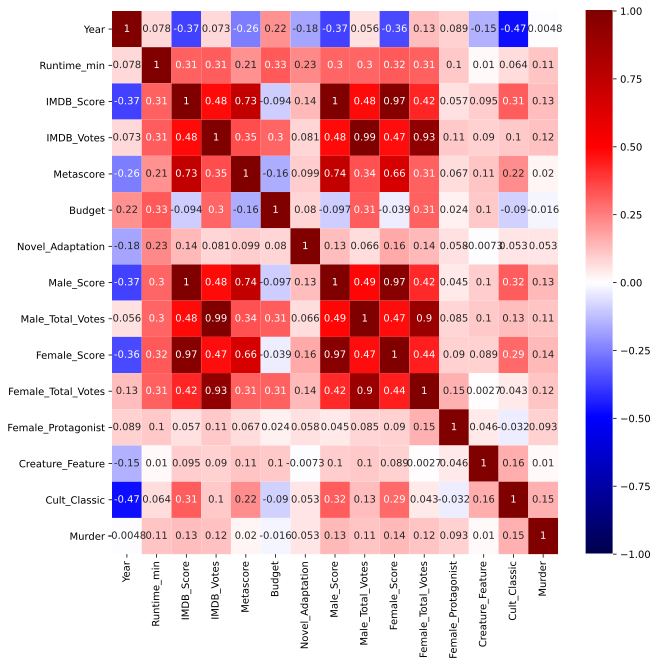

In [5]:
horror_df.corr()
fig=plt.figure(figsize=(10,10))
sns.heatmap(horror_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('Heatmap.svg',format='svg');

In [6]:
Xm=horror_df.loc[:,['Year','Runtime_min','Novel_Adaptation',
                  'Female_Protagonist','Creature_Feature',
                  'Cult_Classic','Murder','Budget','Metascore']]
y=horror_df['Female_Score']

In [7]:
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(horror_df.Genres)
Genre_dum=pd.DataFrame(dum,horror_df.index,mlb.classes_)
combined_X=pd.concat([Genre_dum,Xm],axis=1)
Xm=combined_X
y=horror_df['Female_Score']

In [8]:
dir_counts=horror_df.Director.value_counts()
other_d = list(dir_counts[dir_counts <= 3].index)
Xm['Director']=horror_df['Director'].replace(other_d,'Other')
Xm=pd.get_dummies(Xm,drop_first=True)
y=horror_df['Female_Score']

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(Xm, y, test_size=0.2,random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=41)

In [10]:
model=sm.OLS(y_train,sm.add_constant(X_train))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Female_Score   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     10.05
Date:                Sun, 24 Jan 2021   Prob (F-statistic):           1.38e-47
Time:                        19:33:16   Log-Likelihood:                -314.88
No. Observations:                 408   AIC:                             753.8
Df Residuals:                     346   BIC:                             1002.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           32.0118      4.101      7.805      0.000      23.945      40.079
 Adventure                       0.2872      0.240      1.198      0.232      -0.184       0.759
 Comedy                          0.4742      0.260      1.825      0.069      -0.037       0.985
 Comedy                          3.1078      0.610      5.097      0.000       1.908       4.307
 Crime                           0.5816      0.305      1.905      0.058      -0.019       1.182
 Crime                           3.2039      0.511      6.275      0.000       2.200       4.208
 Drama                           0.1227      0.200      0.615      0.539      -0.270       0.515
 Drama                           3.0263      0.505      5.992      0.000       2.033       4.020
 Family                          0.2556      0.448      0.570      0.569      -0.626       1.137
 Family                          3.4717      0.590      5.887      0.000       2.312       4.632
 Fantasy                         0.2603      0.154      1.690      0.092      -0.043       0.563
 Fantasy                         3.0250      0.436      6.945      0.000       2.168       3.882
 History                        -0.0989      0.621     -0.159      0.873      -1.320       1.122
 Horror                          2.0781      0.318      6.536      0.000       1.453       2.703
 Horror                          3.2690      0.424      7.713      0.000       2.435       4.103
 Music                           0.0091      0.602      0.015      0.988      -1.174       1.193
 Musical                         1.8450      0.678      2.719      0.007       0.511       3.179
 Musical                         1.4289      0.433      3.301      0.001       0.578       2.280
 Mystery                        -0.0076      0.114     -0.066      0.947      -0.233       0.218
 Mystery                         1.1484      0.201      5.726      0.000       0.754       1.543
 Romance                         0.6415      0.400      1.603      0.110      -0.145       1.428
 Sci-Fi                          0.2580      0.223      1.157      0.248      -0.181       0.697
 Sci-Fi                          1.0726      0.194      5.529      0.000       0.691       1.454
 Thriller                        1.2426      0.193      6.428      0.000       0.862       1.623
 Western                         1.1649      0.538      2.166      0.031       0.107       2.223
Action                           2.7480      0.376      7.300      0.000       2.008       3.488
Adventure                        2.2597      0.365      6.191      0.000       1.542       2.978
Animation                        2.9329      0.589      4.976      0.000       1.774       4.092
Biography                        2.2023      0.677      3.251      0.001    

In [11]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
val_score=lr_model.score(X_val,y_val)
val_score

0.45010418794460716

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xm, y, test_size=0.2,random_state=41)

In [31]:
alpha_list=np.logspace(-10,10,100)
params_Ridge={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipe=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Ridge(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipe.fit(X_train,y_train)
robust_pred=pipe.predict(X_test)

In [32]:
r2_score(y_test,robust_pred)

0.5160578911765015

In [34]:
#attempt to calculate adjusted r2, big difference not sure if calculated correctly, going to look at error metrics
SS_Residual = sum((y_test-robust_pred)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

0.07982838463137598

In [15]:
ridge_coef=list(zip(X_train.columns, pipe.named_steps['search'].best_estimator_.coef_))
ridge_coef
filtered=[(coef,val) for coef,val in ridge_coef if val !=0]
sorted(filtered,key=lambda x: abs(x[1]))

[('Director_William Brent Bell', 0.0001444433188859011),
 (' Mystery', 0.0022582473148203704),
 ('Director_David Cronenberg', 0.004186789055924834),
 ('Director_Greg McLean', -0.00467313220399079),
 (' Horror            ', 0.006987888567039042),
 (' Music', -0.007694530961946576),
 (' Western            ', -0.013361368691160572),
 ('Budget', 0.020193561857201624),
 (' Family', -0.021333453307244725),
 ('Novel_Adaptation', 0.021838617293695035),
 (' Drama            ', -0.023806500907516893),
 (' History', -0.025490489112138887),
 (' Adventure', -0.02851334076906728),
 ('Director_Guillermo del Toro', -0.029295938664300605),
 (' Drama', -0.029307738329954057),
 (' Thriller            ', -0.031062973663009412),
 (' Romance            ', -0.03188743334056505),
 ('Cult_Classic', 0.03213900892610108),
 ('Director_Joe Dante', -0.032914045757512056),
 (' Horror', -0.0363323372688834),
 (' Sci-Fi            ', -0.03751959401338251),
 (' Musical            ', 0.03804807443135751),
 ('Fantasy', 0

In [16]:
params_Lasso={'alpha':np.logspace(-10,10,100),"fit_intercept":[True,False]}
pipeL=Pipeline(steps=[
    ('rs',RobustScaler()),
    ('search',GridSearchCV(Lasso(),
                          param_grid=params_Ridge,
                          cv=5,
                          refit=True))
])
pipeL.fit(X_train,y_train)
robust_predL=pipeL.predict(X_test)

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.010609650516216, tolerance: 0.03408914942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.797243412037425, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8379326597001295, tolerance: 0.03332474942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.38438325524599, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.321205103022216, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.7404024805062, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.38441449852289, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.32123684075211, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.74043440668106, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.837949728305659, tolerance: 0.03332474942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.08329429137656, tolerance: 0.033221370114942535
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.153340131777739, tolerance: 0.034324722477064216
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/py

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.83798204159072, tolerance: 0.03332474942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.083339612308905, tolerance: 0.033221370114942535
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.153367081982694, tolerance: 0.034324722477064216
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/py

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.010799178779251, tolerance: 0.03408914942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.797543214213768, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.83811214566532, tolerance: 0.03332474942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/py

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.111358482134, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.011370867947036, tolerance: 0.03408914942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.798453232687677, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.13267719628768, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.013664951914407, tolerance: 0.03408914942528736
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.802106133076933, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/si

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.49456324879766, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.43432147951425, tolerance: 1.696425
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.85520998039761, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.926508107454836, tolerance: 0.034324722477064216
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.36817697804312, tolerance: 1.6723029999999999
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.813539513784235, tolerance: 1.6840309999999998
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/pyth

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.52374857789166, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.89478207400077, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0756879480709074, tolerance: 0.033274197701149436
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.16104748942854, tolerance: 1.675488
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.45750547747065, tolerance: 1.682033
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.1413921107101, tolerance: 1.6723029999999999
  model = cd_fast.enet_coordinate_descent(
/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklea

In [17]:
r2_score(y_test,robust_predL)

0.503013274678423

In [26]:
SS_Residual = sum((y_test-robust_predL)**2)       
SS_Total = sum((y_test-np.mean(y_test))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adjusted_r_squared

0.05502524058573399

In [18]:
lasso_coef=list(zip(X_train.columns, pipeL.named_steps['search'].best_estimator_.coef_))
lasso_coef
filteredL=[(coef,val) for coef,val in lasso_coef if val !=0]
sorted(filteredL,key=lambda x: abs(x[1]))

[(' Mystery', -0.00086366563952671),
 ('Action', 0.003934772926640455),
 ('Director_Other', -0.011726459434422486),
 (' Horror            ', 0.012032625157569693),
 ('Cult_Classic', 0.012952441802921629),
 ('Director_Paul W.S. Anderson', 0.013977838491839277),
 ('Director_John Carpenter', 0.020918471265091918),
 (' Fantasy', 0.021651251683623026),
 (' Sci-Fi', 0.0250637918550882),
 ('Budget', 0.026519822341340416),
 (' Mystery            ', -0.028250127068871506),
 (' Crime', 0.03710169494026135),
 (' Horror', -0.039003017136856374),
 ('Creature_Feature', -0.0753833395856674),
 ('Female_Protagonist', 0.07893918844584964),
 ('Crime', 0.08774215246213343),
 ('Comedy', -0.0910174943486295),
 ('Runtime_min', 0.17536216447534994),
 ('Horror', -0.17997079998911045),
 ('Director_George A. Romero', -0.1819611575969729),
 ('Murder', 0.1988891832760763),
 (' Comedy', 0.2589983082665924),
 ('Director_Wes Craven', -0.3065203454928022),
 ('Adventure', -0.3119721356498125),
 ('Year', -0.312545430219

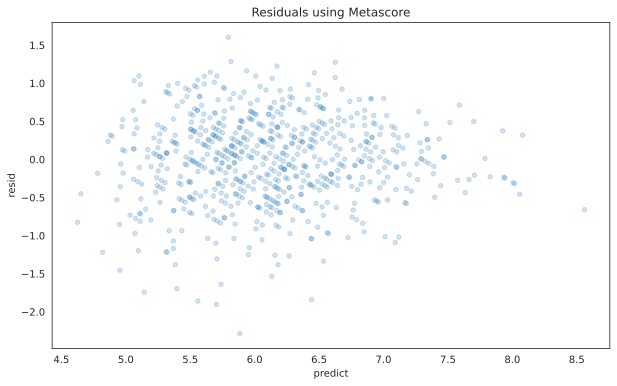

In [19]:
horror_df['predict']=pipeL.predict(Xm)
horror_df['resid']=y-horror_df.predict
with sns.axes_style('white'):
    plot=horror_df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.title('Residuals using Metascore')    
plt.savefig('metascore_residual_scatter.svg',format='svg')

In [20]:
horror_df.sort_values(['resid']).head(10)

,Movie,Year,Runtime_min,Genres,IMDB_Score,IMDB_Votes,Metascore,Director,Star,Budget,...,Male_Total_Votes,Female_Score,Female_Total_Votes,Link_stub,Female_Protagonist,Creature_Feature,Cult_Classic,Murder,predict,resid
678,Texas Chainsaw Massacre: The Next Generation,1994,87,"[Comedy, Horror, Thriller ]",3.3,20058,50,Kim Henkel,"[Renée Zellweger, Matthew McConaughey, Robert ...",600000,...,13530,3.6,2038,/title/tt0110978/,0,0,0,0,5.885398,-2.285398
670,The Wicker Man,2006,102,"[Horror, Mystery, Thriller ]",3.7,64208,36,Neil LaBute,"[Nicolas Cage, Ellen Burstyn, Leelee Sobieski]",40000000,...,44115,3.8,9096,/title/tt0450345/,0,0,1,1,5.702550,-1.902550
674,Dragon Wars: D-War,2007,107,"[Action, Drama, Fantasy ]",3.5,23677,33,Hyung-rae Shim,"[Jason Behr, Amanda Brooks, Robert Forster]",32000000,...,18319,3.7,1989,/title/tt0372873/,0,1,1,0,5.559013,-1.859013
588,Universal Soldier: Day of Reckoning,2012,114,"[Action, Horror, Mystery ]",5.0,19281,58,John Hyams,"[Jean-Claude Van Damme, Dolph Lundgren, Scott ...",10000000,...,15631,4.6,1060,/title/tt1659343/,0,0,0,1,6.440862,-1.840862
679,Slender Man,2018,93,"[Horror, Mystery, Thriller ]",3.2,28703,30,Sylvain White,"[Joey King, Julia Goldani Telles, Jaz Sinclair]",10000000,...,14850,3.4,4180,/title/tt5690360/,0,1,0,1,5.143904,-1.743904
677,Feardotcom,2002,101,"[Crime, Horror, Thriller ]",3.4,20225,16,William Malone,"[Stephen Dorff, Natascha McElhone, Stephen Rea]",40000000,...,12518,3.7,2990,/title/tt0295254/,0,0,0,1,5.396593,-1.696593
676,Black Christmas,2019,92,"[Horror, Mystery, Thriller ]",3.4,11847,49,Sophia Takal,"[Imogen Poots, Aleyse Shannon, Lily Donoghue]",5000000,...,6666,4.1,1444,/title/tt10481868/,0,0,1,1,5.738897,-1.638897
597,Halloween III: Season of the Witch,1982,98,"[Horror, Mystery, Sci-Fi ]",5.0,43871,50,Tommy Lee Wallace,"[Tom Atkins, Stacey Nelkin, Dan O'Herlihy]",2500000,...,29607,4.6,3520,/title/tt0085636/,0,0,1,0,6.133623,-1.533623
669,Piranha 3DD,2012,83,"[Comedy, Horror ]",3.7,39917,24,John Gulager,"[Danielle Panabaker, Ving Rhames, David Hassel...",5000000,...,29833,3.5,3930,/title/tt1714203/,0,0,0,0,4.954018,-1.454018
671,The Fog,2005,100,"[Horror, Mystery ]",3.7,35013,27,Rupert Wainwright,"[Tom Welling, Maggie Grace, Selma Blair]",18000000,...,23263,4.0,5443,/title/tt0432291/,0,0,1,1,5.383684,-1.383684


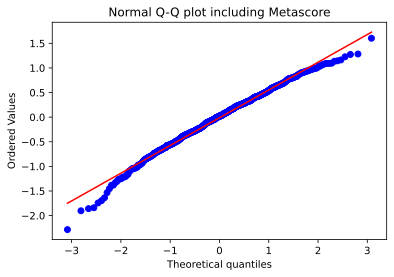

In [21]:
stats.probplot(horror_df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot including Metascore")
plt.savefig('Metascore_qq.svg',format='svg')
plt.show();

In [22]:
X_te=np.arange(0,len(X_test),1)

In [23]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, robust_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, robust_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, robust_pred)))

Mean Absolute Error: 0.43484235936844
Mean Squared Error: 0.3130416789443559
Root Mean Squared Error: 0.5595012769818813


In [24]:
from yellowbrick.regressor import PredictionError
visualizer=PredictionError(pipe)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
plt.savefig('metascore_predictionerror.svg',format='svg')
visualizer.show();


ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
#plt.scatter(X_train['Metascore'],y_train, color='red')
plt.scatter(X_test['Metascore'],y_test, color='blue',alpha=0.6,label="Actual") #actual
plt.scatter(X_test['Metascore'],robust_pred, color="black", alpha=0.6,label="Predicted")
plt.title('Actual vs Predicted Test Values')
plt.ylabel("Women's IMDB Score")
plt.xlabel('Metascore')
plt.legend(); #predicted
plt.savefig('metascore_predicted_actual_scatter.svg',format='svg')